In [2]:
# Dependencies
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

# US Census setup
from census import Census
from us import states
from config import census_key

In [2]:
# Retrieve US censue data and create dataframe
census_library = Census(census_key, year=2021)
state_code = states.CA.fips
variables = [
    'NAME',
    'B01003_001E',  # Population
    'B25014_001E',  # Total Housing units
    'B25014_005E',  # Housing units owner occupied, 1-1.5 occupants per room
    'B25014_006E',  # Housing units owner occupied, 1.5-2 occupants per room
    'B25014_007E',  # Housing units owner occupied, >2 occupants per room
    'B25014_011E',  # Housing units renter occupied, 1-1.5 occupants per room
    'B25014_012E',  # Housing units renter occupied, 1.5-2 occupants per room
    'B25014_013E',  # Housing units renter occupied, >2 occupants per room   
    'B25106_003E',  # Housing units owner occupied, income <20K
    'B25106_006E',  # Housing units owner occupied, income <20K, housing costs >=30% of income
    'B25106_007E',  # Housing units owner occupied, income 20-35K
    'B25106_010E',  # Housing units owner occupied, income 20-35K, housing costs >=30% of income
    'B25106_011E',  # Housing units owner occupied, income 35-50K
    'B25106_014E',  # Housing units owner occupied, income 35-50K, housing costs >=30% of income
    'B25106_025E',  # Housing units renter occupied, income <20K
    'B25106_028E',  # Housing units renter occupied, income <20K, housing costs >=30% of income
    'B25106_029E',  # Housing units renter occupied, income 20-35K
    'B25106_032E',  # Housing units renter occupied, income 20-35K, housing costs >=30% of income
    'B25106_033E',  # Housing units renter occupied, income 35-50K
    'B25106_036E'   # Housing units renter occupied, income 35-50K, housing costs >=30% of income  
]

# Retrieve data for all counties in California
data = census_library.acs5.state_county(variables, state_code, Census.ALL)

# Convert to dataframe
housing_df = pd.DataFrame(data)

# Export raw data to csv
url_path = Path('output_data/housing_raw_data.csv')
housing_df.to_csv(url_path, index=False)

# Print the DataFrame
housing_df.head()

,NAME,B01003_001E,B25014_001E,B25014_005E,B25014_006E,B25014_007E,B25014_011E,B25014_012E,B25014_013E,B25106_003E,...,B25106_011E,B25106_014E,B25106_025E,B25106_028E,B25106_029E,B25106_032E,B25106_033E,B25106_036E,state,county
0,"Alameda County, California",1673133.0,581683.0,8779.0,2077.0,568.0,20199.0,10411.0,2893.0,12117.0,...,14914.0,8546.0,33224.0,29275.0,26673.0,24128.0,23024.0,19821.0,06,001
1,"Alpine County, California",1344.0,434.0,5.0,1.0,0.0,8.0,0.0,0.0,20.0,...,17.0,6.0,4.0,4.0,23.0,2.0,6.0,2.0,06,003
2,"Amador County, California",40095.0,15394.0,173.0,22.0,47.0,82.0,124.0,0.0,995.0,...,1513.0,797.0,568.0,513.0,449.0,449.0,393.0,269.0,06,005
3,"Butte County, California",217884.0,85292.0,720.0,199.0,58.0,1431.0,536.0,48.0,4388.0,...,4819.0,1809.0,7396.0,6970.0,6850.0,6126.0,4921.0,3133.0,06,007
4,"Calaveras County, California",45349.0,16809.0,147.0,109.0,0.0,87.0,9.0,12.0,1220.0,...,1595.0,867.0,584.0,550.0,443.0,384.0,367.0,334.0,06,009


In [3]:
# Use this to recreate dataframe if starting a new Jupyter session or Kernal
url_path = Path('output_data/housing_raw_data.csv')
housing_df = pd.read_csv(url_path)

In [4]:
# Clean up data and add calculated columns

# Rename existing columns
housing_df = housing_df.rename(
    columns = {
        'NAME': 'County',
        'B01003_001E': 'Population',
        'B25014_001E': 'Total Housing Units'
    }
)

# Remove California from data in County column
housing_df['County'] = housing_df['County'].str.replace(', California','')

# Add columns rolling up data on overcrowded housing units
housing_df['Units Overcrowded'] = housing_df['B25014_005E'] + housing_df['B25014_011E']
housing_df['Units Severely Overcrowded'] = (housing_df['B25014_006E'] + housing_df['B25014_007E'] +
                                            housing_df['B25014_012E'] + housing_df['B25014_012E']
                                           )

# Add columns rolling up data on housing units based on housing costs and household income
housing_df['Units Income < 50K'] = (housing_df['B25106_003E'] + housing_df['B25106_007E'] +
                                    housing_df['B25106_011E'] + housing_df['B25106_025E'] +
                                    housing_df['B25106_029E'] + housing_df['B25106_033E']
                                   )
housing_df['Units Costs >= 30%'] = (housing_df['B25106_006E'] + housing_df['B25106_010E'] +
                                    housing_df['B25106_014E'] + housing_df['B25106_028E'] +
                                    housing_df['B25106_032E'] + housing_df['B25106_036E']
                                   )

# Remove unneeded columns
# https://sparkbyexamples.com/pandas/pandas-drop-columns-by-index/
housing_clean_df = housing_df.drop(housing_df.iloc[:, 3:23], axis = 1)

# Export clean data to csv
url_path = Path('output_data/housing_clean_data.csv')
housing_clean_df.to_csv(url_path, index=False)

# Print the dataframe
housing_clean_df.head()

,County,Population,Total Housing Units,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%
0,Alameda County,1673133.0,581683.0,28978.0,23467.0,125074.0,103256.0
1,Alpine County,1344.0,434.0,13.0,1.0,111.0,31.0
2,Amador County,40095.0,15394.0,255.0,317.0,5148.0,3583.0
3,Butte County,217884.0,85292.0,2151.0,1329.0,34012.0,24444.0
4,Calaveras County,45349.0,16809.0,234.0,127.0,5667.0,4173.0


In [5]:
# Create final housing dataframe that includes CoC and % calculations for comparison with 
url_path = Path('Resources/County-CoC Mapping.csv')
coc_mapping = pd.read_csv(url_path)

# Create new dataframe with housing and CoC data
housing_coc_df = pd.merge(housing_clean_df, coc_mapping, on='County', how='left')
housing_coc_df = housing_coc_df.groupby('Continuum of Care').sum(numeric_only=True).reset_index()

print(len(housing_coc_df))
housing_coc_df.head()

41


,Continuum of Care,Population,Total Housing Units,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%
0,Alameda County CoC,1673133.0,581683.0,28978.0,23467.0,125074.0,103256.0
1,"Alpine, Inyo, Mono Counties CoC",33439.0,13627.0,326.0,73.0,4326.0,2544.0
2,"Amador, Calaveras, Mariposa, Tuolumne Counties...",157912.0,62894.0,1149.0,736.0,22432.0,15749.0
3,Butte County CoC,217884.0,85292.0,2151.0,1329.0,34012.0,24444.0
4,"Colusa, Glenn, Trinity Counties CoC",66273.0,22548.0,740.0,227.0,9830.0,6009.0


In [8]:
# Use this to recreate dataframe if starting a new Jupyter session or Kernal
url_path = Path('resources/experiencing_homelessness_age_demographics.csv')
homeless_df = pd.read_csv(url_path)

In [52]:
# Clean up data and calculate 5 year average

# Rename existing columns
homeless_df = homeless_df.rename(
    columns = {
        'CALENDAR_YEAR': 'Year',
        'COC_ID': 'CoC Code',
        'COC_NAME': 'Continuum of Care',
        'EXPERIENCING_HOMELESSNESS_CNT': 'Homeless Count'
    }
)

# Change homeless count data type to integer
homeless_df = homeless_df.loc[homeless_df['Homeless Count']!='*']
homeless_df['Homeless Count'] = homeless_df['Homeless Count'].astype(int)

# Remove counts for California and years 2021 and 2022
homeless_df = homeless_df.loc[(homeless_df['Continuum of Care']!='California') &
                             (homeless_df['Year'] < 2021)]

# Rename multiple CoCs in LA so they roll up into one number per year
la_cocs = ['Glendale CoC (Los Angeles County)', 'Pasadena CoC (Los Angeles County)', 'Long Beach CoC (Los Angeles County)']
homeless_df['Continuum of Care'] = homeless_df['Continuum of Care'].replace(la_cocs, 'Los Angeles County CoC')

# Group by year and COC name and sum homeless counts
homeless_df = homeless_df.groupby(['Year', 'Continuum of Care'])['Homeless Count'].sum().reset_index()

# Group by CoC and calculate average homeless count for each county
homeless_mean = homeless_df.groupby('Continuum of Care')['Homeless Count'].mean().reset_index()

# Print row and countthe dataframe
print(len(homeless_mean))
homeless_mean.head()

41


,Continuum of Care,Homeless Count
0,Alameda County CoC,7591.75
1,"Alpine, Inyo, Mono Counties CoC",181.00
2,"Amador, Calaveras, Mariposa, Tuolumne Counties...",387.25
3,Butte County CoC,1636.50
4,"Colusa, Glenn, Trinity Counties CoC",363.00


In [62]:
# Create new dataframe merging housing and homeless data
housing_homeless_df = pd.merge(housing_coc_df, homeless_mean, on='Continuum of Care', how='left')

# Add columns to calculate %s of overcrowded units
housing_homeless_df['% Units Overcrowded'] = (housing_homeless_df['Units Overcrowded'] /
                                              housing_homeless_df['Total Housing Units']) * 100
housing_homeless_df['% Units Severely Overcrowded'] = (housing_homeless_df['Units Severely Overcrowded'] /
                                                       housing_homeless_df['Total Housing Units']) * 100
housing_homeless_df['% Units All Overcrowded'] = ((housing_homeless_df['Units Overcrowded'] +
                                                   housing_homeless_df['Units Severely Overcrowded']) /
                                                  housing_homeless_df['Total Housing Units']) * 100

# Add columns to calculate % of housing units with costs >= 30%
housing_homeless_df['% Units Inc < 50K Costs >= 30%'] = (housing_homeless_df['Units Costs >= 30%'] /
                                                     housing_homeless_df['Units Income < 50K']) * 100
housing_homeless_df['% Units Costs >= 30%'] = (housing_homeless_df['Units Costs >= 30%'] /
                                             housing_homeless_df['Total Housing Units']) * 100

# Add column to calculation homeless % of population
housing_homeless_df['% Homeless'] = (housing_homeless_df['Homeless Count'] /
                                     housing_homeless_df['Population']) * 100
# Export final data to csv
url_path = Path('output_data/housing_homeless_data.csv')
housing_homeless_df.to_csv(url_path, index=False)

# Print the dataframe
housing_homeless_df

,Continuum of Care,Population,Total Housing Units,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%,Homeless Count,% Units Overcrowded,% Units Severely Overcrowded,% Units All Overcrowded,% Units Inc < 50K Costs >= 30%,% Units Costs >= 30%,% Homeless
0,Alameda County CoC,1673133.0,581683.0,28978.0,23467.0,125074.0,103256.0,7591.75,4.981751,4.034328,9.016079,82.555927,17.751249,0.453745
1,"Alpine, Inyo, Mono Counties CoC",33439.0,13627.0,326.0,73.0,4326.0,2544.0,181.00,2.392309,0.535701,2.928011,58.807212,18.668819,0.541284
2,"Amador, Calaveras, Mariposa, Tuolumne Counties...",157912.0,62894.0,1149.0,736.0,22432.0,15749.0,387.25,1.826883,1.170223,2.997106,70.207739,25.040544,0.245232
3,Butte County CoC,217884.0,85292.0,2151.0,1329.0,34012.0,24444.0,1636.50,2.521925,1.558177,4.080101,71.868752,28.659194,0.751088
4,"Colusa, Glenn, Trinity Counties CoC",66273.0,22548.0,740.0,227.0,9830.0,6009.0,363.00,3.281888,1.006741,4.288629,61.129196,26.649814,0.547734
5,Contra Costa County CoC,1161643.0,405106.0,14159.0,9916.0,80749.0,66060.0,5618.25,3.495135,2.447754,5.942889,81.809063,16.306843,0.483647
6,El Dorado County CoC,190568.0,74535.0,1155.0,461.0,19268.0,14766.0,204.25,1.549608,0.618501,2.168109,76.634835,19.810827,0.107180
7,"Fresno, Madera Counties CoC",1159454.0,357999.0,21329.0,17108.0,139405.0,104045.0,2781.75,5.957838,4.778784,10.736622,74.635056,29.062930,0.239919
8,Humboldt County CoC,137014.0,53729.0,1517.0,1372.0,23725.0,17541.0,1366.00,2.823429,2.553556,5.376984,73.934668,32.647174,0.996978
9,Imperial County CoC,180051.0,45541.0,2539.0,1911.0,22185.0,14831.0,798.50,5.575196,4.196219,9.771415,66.851476,32.566259,0.443485


The r-squared is: 0.020348652329998912


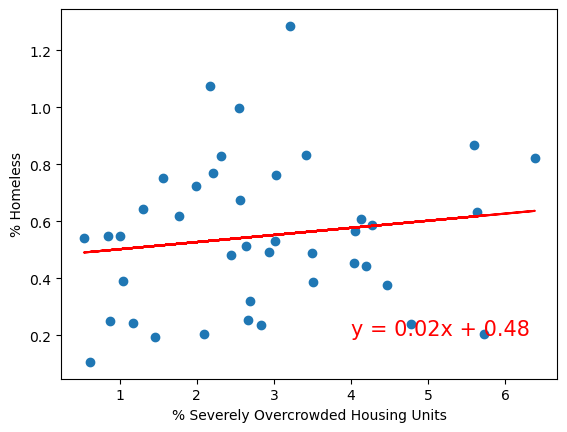

In [63]:
# Test charts if LA is removed
# housing_homeless_df = housing_homeless_df.loc[housing_homeless_df['Continuum of Care']!='Los Angeles County CoC']

x_values = housing_homeless_df['% Units Severely Overcrowded']
y_values = housing_homeless_df['% Homeless']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(4, .2),fontsize=15,color="red")
plt.xlabel('% Severely Overcrowded Housing Units')
plt.ylabel('% Homeless')
print(f"The r-squared is: {rvalue**2}")
plt.show()

41
The r-squared is: 0.9750717882320984


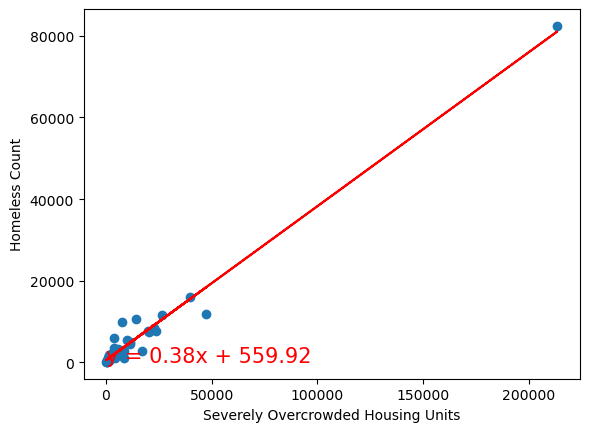

In [64]:
x_values = housing_homeless_df['Units Severely Overcrowded']
y_values = housing_homeless_df['Homeless Count']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(4, .2),fontsize=15,color="red")
plt.xlabel('Severely Overcrowded Housing Units')
plt.ylabel('Homeless Count')
print(len(x_values))
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.015311301553189657


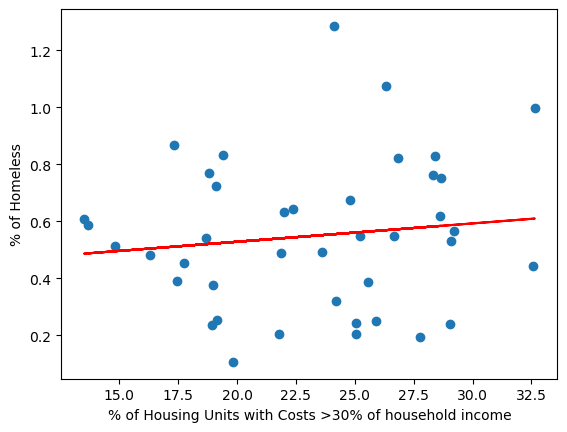

In [65]:
x_values = housing_homeless_df['% Units Costs >= 30%']
y_values = housing_homeless_df['% Homeless']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(4, .2),fontsize=15,color="red")
plt.xlabel('% of Housing Units with Costs >30% of household income')
plt.ylabel('% of Homeless')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.958750190101281


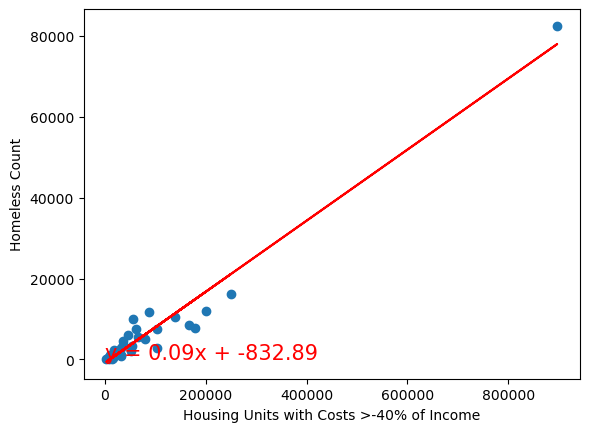

In [66]:
x_values = housing_homeless_df['Units Costs >= 30%']
y_values = housing_homeless_df['Homeless Count']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(4, .2),fontsize=15,color="red")
plt.xlabel('Housing Units with Costs >-40% of Income')
plt.ylabel('Homeless Count')
print(f"The r-squared is: {rvalue**2}")
plt.show()

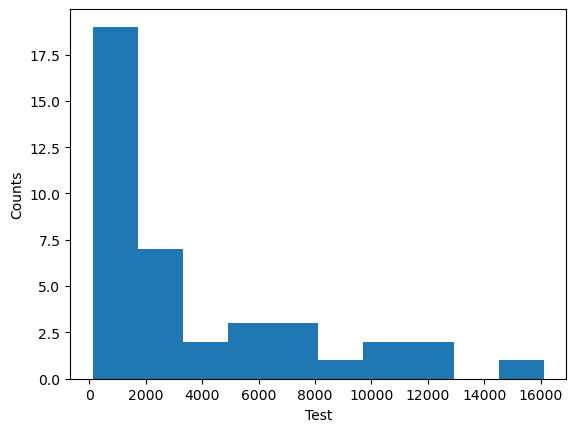

NormaltestResult(statistic=12.922500714716724, pvalue=0.0015628403792494305)


In [61]:
# For testing normal distribution of any data
#url_path = Path('output_data/housing_homeless_data.csv')
#housing_homeless_df = pd.read_csv(url_path)

test_data = housing_homeless_df['Homeless Count']
plt.hist(test_data)
plt.xlabel('Test')
plt.ylabel('Counts')
plt.show()
print(st.normaltest(test_data))